In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import PIL
from tensorflow.keras import layers
from tensorflow.keras import utils as keras_utils
import time
from IPython import display
import cv2 as cv
%matplotlib inline

# avoid displaying warnings in notebook (still visible in console)
import warnings
warnings.filterwarnings('ignore')
# tf.debugging.set_log_device_placement(True)


Tensorflow version: 2.1.0


In [2]:
def show_batch(image_batch, label_batch, idx_to_class):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        if image_batch[n].shape[-1] == 1:
            plt.imshow(image_batch[n].squeeze(), cmap='gray')
        else:
            plt.imshow(image_batch[n])
        plt.title(idx_to_class[label_batch[n].argmax()])
        plt.axis('off')

def show_image(image, title='test'):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')

Load image into a generator

In [3]:
BATCH_SIZE = 32
BUFFER_SIZE = 60000
base_path = "D:\\Datasets\\data" #"C:\\Users\\SVILUPPO1\\Documents\\test-ai\\data"
training_path = os.path.join(base_path, 'augmented_termoplast', 'training')
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
train_data_gen = train_datagen.flow_from_directory(training_path, color_mode='grayscale', shuffle=True, batch_size=BATCH_SIZE, class_mode='categorical', target_size=(180, 216))
index_to_class = {v: k for k, v in train_data_gen.class_indices.items()}

Found 1150 images belonging to 6 classes.


preview of the data

True

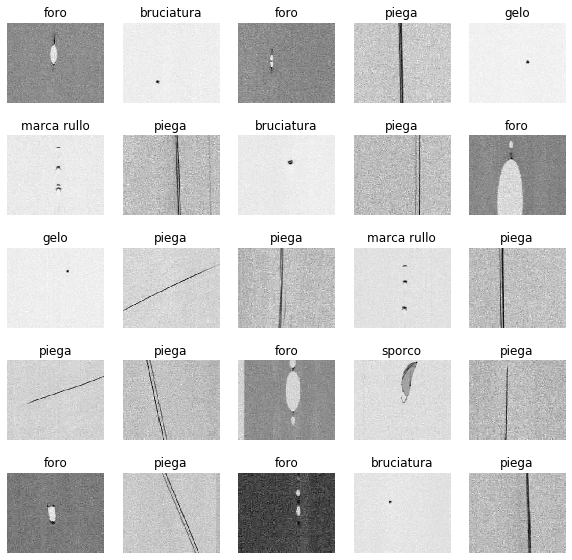

In [4]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch, index_to_class)
cv.imwrite(os.path.join(base_path, 'train_images', 'adnetPlot', 'test.bmp'), image_batch[0])

In [5]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [6]:
NOISE_DIMENSION = 1000

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10*12*256, use_bias=False, input_shape=(NOISE_DIMENSION,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((10, 12, 256)))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(3, 3), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    print('Generator output', model.output_shape)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[180, 216, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Create generator

In [7]:
print("Generator creation")
generator = make_generator_model()
generator.summary()

Generator creation
Generator output (None, 180, 216, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30720)             30720000  
_________________________________________________________________
batch_normalization (BatchNo (None, 30720)             122880    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30720)             0         
_________________________________________________________________
reshape (Reshape)            (None, 10, 12, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 12, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 12, 128)       512       
_________________________________________________________________


Generate noise
pass noise to generator
Plot result


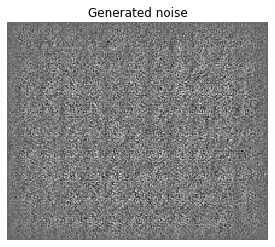

In [8]:
print("Generate noise")
noise = tf.random.normal([1, NOISE_DIMENSION])
print("pass noise to generator")
generated_image = generator(noise, training=False)
print("Plot result")
show_image(generated_image[0, :, :, 0], 'Generated noise')

Create Discriminator

In [9]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 108, 128)      3328      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 90, 108, 128)      0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 108, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 54, 128)       409728    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 45, 54, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 27, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 27, 128)      

Save checkpoints

In [11]:
checkpoint_dir = os.path.join(base_path, 'training_checkpoints_DCGAN')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define the training loop

In [12]:
EPOCHS = 20
# EPOCHS = 10
nsample_per_ephoc = 1000
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIMENSION])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIMENSION])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator((images - 127.5) / 127.5, training=True) # Normalize the images to [-1, 1] so they are in the same range of the generator output
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [13]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(20, 20))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(os.path.join(base_path, 'train_images','image_at_epoch_{:04d}.png').format(epoch))
    plt.show()
    first_image = np.array(predictions[0, :, :, 0]) * 127.5 + 127.5
    cv.imwrite(os.path.join(base_path, 'train_images', 'adnetPlot', 'image_at_epoch_{:04d}.png').format(epoch), first_image)

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        nsample = 0
        for image_batch, _ in dataset:
            train_step(image_batch)
            nsample = nsample + 1
            if nsample == nsample_per_ephoc:
                break
        print("End training for epoch {}".format(epoch))
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


Train the model

In [14]:
train(train_data_gen, EPOCHS)

KeyboardInterrupt: 

In [ ]:
print("Generate noise")
noise = tf.random.normal([1, NOISE_DIMENSION])
print("pass noise to generator")
generated_image = generator(noise, training=False)
print("Plot result")
first_image = np.array(generated_image[0, :, :, 0]) * 127.5 + 127.5
show_image(first_image, 'Generated noise')
cv.imwrite(os.path.join(base_path, 'train_images', 'adnetPlot', 'test.bmp'), first_image)

In [ ]:
generator.save(os.path.join(checkpoint_dir, 'generator'))
discriminator.save(os.path.join(checkpoint_dir, 'discriminator'))

In [ ]:
checkpoint_dir = os.path.join(base_path, 'training_checkpoints_DCGAN')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
generator = tf.keras.models.load_model(os.path.join(checkpoint_dir, 'generator'))
discriminator = tf.keras.models.load_model(os.path.join(checkpoint_dir, 'discriminator'))